# Feature Selection 

Testing some methods for features selection 

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load the dataframe

In [ ]:
path =  r"../../../weldb_clean.csv"  # path to the clean csv 
df = pd.read_csv(path)

In [3]:
df

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy temperature / °C,Charpy impact toughness / J,Hardness / kgmm-2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggreagate / %,Weld ID
0,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32.0,28.0,40.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## VarianceThreshold

Some columns may have almost constant values → not useful. The idea is to remove the columns with low-information, by applying the a variance threshold. 

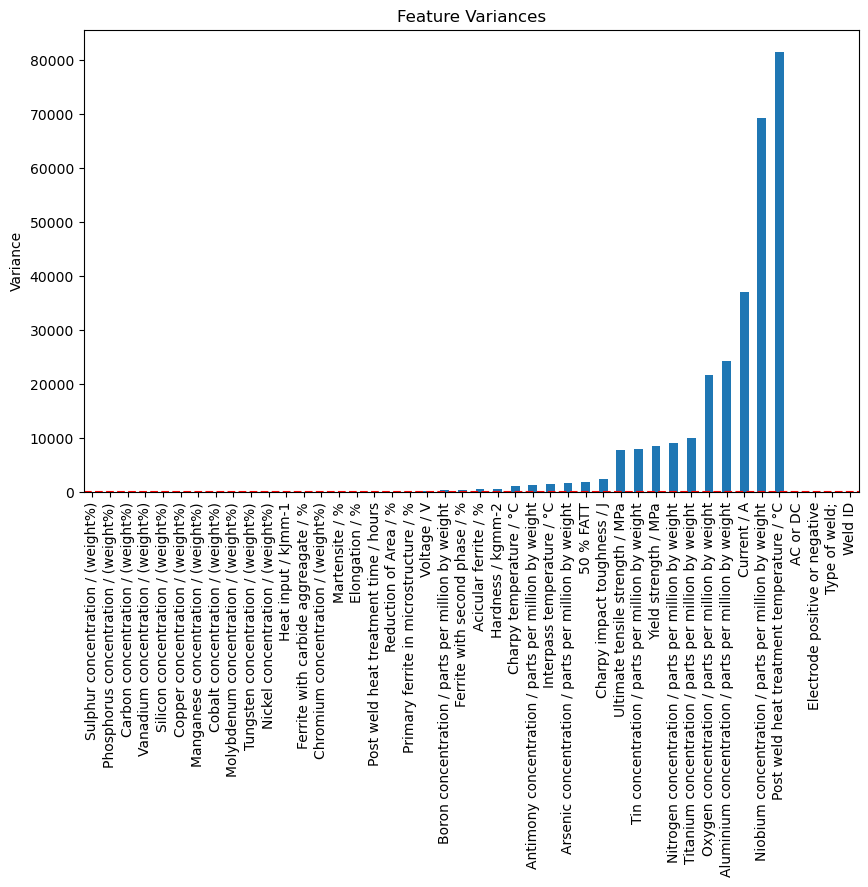

In [29]:
variances = df.var()
plt.figure(figsize=(10,6))
variances.sort_values().plot(kind="bar")
plt.axhline(y=0.01, color="r", linestyle="--")
plt.title("Feature Variances")
plt.ylabel("Variance")
plt.show()


Columns have different units / scales , then variance values are not comparable across features. Need to scale  up before applyong the variance threshold

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("var_thresh", VarianceThreshold(threshold=1))
])

X_reduced = pipeline.fit_transform(df.fillna(0))

# Get feature names after selection
mask = pipeline.named_steps['var_thresh'].get_support()
selected_features = df.columns[mask]
print("Kept features:", selected_features.tolist())


Kept features: ['Sulphur concentration / (weight%)', 'Chromium concentration / (weight%)', 'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)', 'Tungsten concentration / (weight%)', 'Tin concentration / parts per million by weight', 'Ferrite with second phase / %', 'Ferrite with carbide aggreagate / %']


In [28]:
print(len(selected_features))

8


## Correlation filtering

The idea is to remove redundant features; if any two columns are highly correlated.

In [ ]:
corr_matrix = df.corr().abs()  # absolute correlation


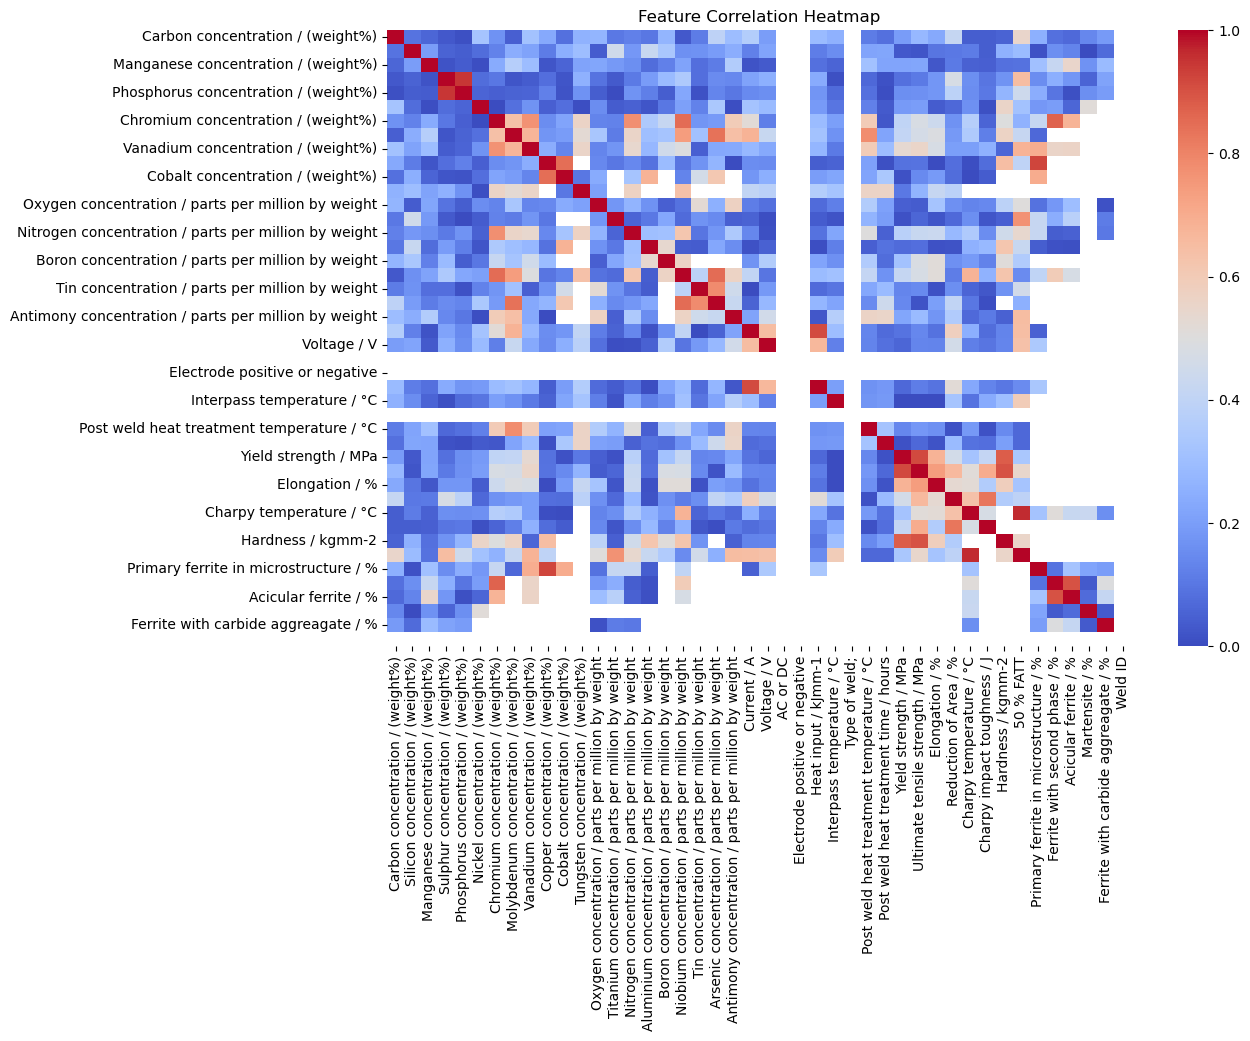

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


## PCA 

Project features into fewer dimensions while keeping maximum variance.

In [ ]:
X = df.fillna(0)  # handle NaN before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [48]:
X_scaled.shape

(1652, 44)

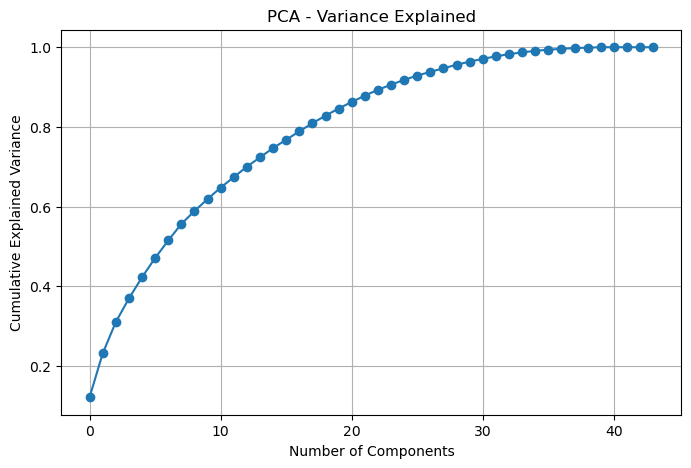

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Variance Explained")
plt.grid(True)
plt.show()


NB:
- The curve rises steeply at the beginning (first ~10 components) → those capture most of the variance.

- After around 15–18 components, the slope flattens → each new component adds only a tiny bit more variance.

- Beyond ~25 components, close to 95–98% cumulative variance → adding more doesn’t bring much.

In [49]:
pca = PCA(n_components=0.95)  # keep 95% variance or maybe only
X_reduced = pca.fit_transform(X_scaled)

print("Original shape:", X.shape)
print("Reduced shape:", X_reduced.shape)


Original shape: (1652, 44)
Reduced shape: (1652, 29)


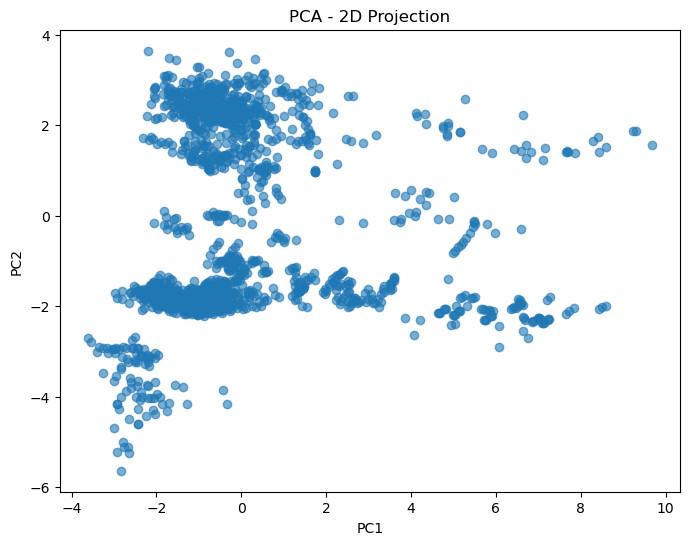

In [50]:
pca = PCA(n_components=29)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - 2D Projection")
plt.show()


In [51]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=df.columns)
print(loadings.head())


                                           PC1       PC2       PC3       PC4  \
Carbon concentration / (weight%)      0.102236  0.017004  0.226580  0.013469   
Silicon concentration / (weight%)    -0.162773  0.032674  0.021116  0.166513   
Manganese concentration / (weight%)  -0.145720  0.025936  0.137529  0.031074   
Sulphur concentration / (weight%)     0.068571  0.048741  0.229620 -0.151777   
Phosphorus concentration / (weight%)  0.087556  0.038299  0.196605 -0.135210   

                                           PC5       PC6       PC7       PC8  \
Carbon concentration / (weight%)      0.060282 -0.180073  0.205166 -0.238481   
Silicon concentration / (weight%)     0.159893 -0.135406  0.085402  0.368333   
Manganese concentration / (weight%)   0.078333 -0.109079  0.215841  0.137800   
Sulphur concentration / (weight%)     0.012538  0.526057  0.117723  0.267762   
Phosphorus concentration / (weight%)  0.059810  0.532942  0.111144  0.286118   

                                      